### *Author: Süheyl Çavuşoğlu*

- Dataset downloaded from https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv


- This dataset includes monthly resolution average temperature data of 159 different countries between 1743 and 2013.

- Due to the large amount of deficiencies in the data sets before 1900, the data between 1900 and 2013 were analyzed in this study.

- Using data from 1900 to 2013, we estimated world average temperatures for 2013-2030 with Facebook Prophet.

- You can download this data set and run your own exploratory data analysis.

You may need to install the libraries given below. ↓ ↓ ↓

In [ ]:
!pip install fbprophet
!pip install pystan

The libraries you need to import are given below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

In [2]:
df = pd.read_csv("GlobalLandTemperaturesByCity.csv") # reading dataset with pandas

In [3]:
# df = pd.read_csv("GlobalLandTemperaturesByCity.csv", parse_dates=['dt']) # reading dataset with pandas. If you want to call the dt column as DATETIME while calling the dataset, you can run this line.

In [3]:
df.head() # first 5 rows of dataset

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [4]:
df.tail() # last 5 rows of dataset

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
8599207,2013-05-01,11.464,0.236,Zwolle,Netherlands,52.24N,5.26E
8599208,2013-06-01,15.043,0.261,Zwolle,Netherlands,52.24N,5.26E
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E
8599211,2013-09-01,NaN,NaN,Zwolle,Netherlands,52.24N,5.26E


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [6]:
all_columns = list(df.columns)
for i in all_columns:
    print("Total null value in {} column:".format(i) , df["{}".format(i)].isnull().sum())

Total null value in dt column: 0
Total null value in AverageTemperature column: 364130
Total null value in AverageTemperatureUncertainty column: 364130
Total null value in City column: 0
Total null value in Country column: 0
Total null value in Latitude column: 0
Total null value in Longitude column: 0


There are 364130 missing values in 'AverageTemperature' column. We need to do something about missing values.

In [7]:
df_1900 = df[df["dt"] >= "1900-01-01"]
df_1900.isnull().sum()

dt                                  0
AverageTemperature               3070
AverageTemperatureUncertainty    3070
City                                0
Country                             0
Latitude                            0
Longitude                           0
dtype: int64

When we examined the missing data after 1900, we saw that only 3070 AverageTemperature data were missing. In other words, most of the missing data belong to before 1900. Therefore, we chose to continue without processing the data before 1900.

In [8]:
df_1900.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4791150 entries, 1874 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 292.4+ MB


Since we will not be examining the "AverageTemperatureUncertainty", "Latitude" and "Longitude" columns, we will delete these columns.

In [9]:
df_1900 = df_1900.drop(['AverageTemperatureUncertainty','Latitude', 'Longitude'], axis=1) # we deleted AverageTemperatureUncertainty, Latitude and Longitude columns.

Now we can delete missing data from 1900 to 2013. Because these missing data are only  0.0006 of our total data. (missing value/ total value ==> 3070/4791150 = 0.0006)

In [10]:
df_1900.isnull().sum()

dt                       0
AverageTemperature    3070
City                     0
Country                  0
dtype: int64

In [11]:
df_1900 = df_1900.dropna(how='any', axis=0)
df_1900.isnull().sum()  # as you see we cleaned our dataset from missing values.

dt                    0
AverageTemperature    0
City                  0
Country               0
dtype: int64

In [12]:
df_1900.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4788080 entries, 1874 to 8599210
Data columns (total 4 columns):
 #   Column              Dtype  
---  ------              -----  
 0   dt                  object 
 1   AverageTemperature  float64
 2   City                object 
 3   Country             object 
dtypes: float64(1), object(3)
memory usage: 182.7+ MB


Our dt column's dtype is "object". We need to make it "datetime"

In [13]:
df_1900['dt'] = pd.to_datetime(df_1900['dt'])

In [14]:
df_1900.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4788080 entries, 1874 to 8599210
Data columns (total 4 columns):
 #   Column              Dtype         
---  ------              -----         
 0   dt                  datetime64[ns]
 1   AverageTemperature  float64       
 2   City                object        
 3   Country             object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 182.7+ MB


We can pull the years from the dt column and examine the monthly resolution data in annual resolution as well.

In [15]:
df_1900["Year"] = df_1900["dt"].dt.year

In [16]:
df_1900.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4788080 entries, 1874 to 8599210
Data columns (total 5 columns):
 #   Column              Dtype         
---  ------              -----         
 0   dt                  datetime64[ns]
 1   AverageTemperature  float64       
 2   City                object        
 3   Country             object        
 4   Year                int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 219.2+ MB


In [17]:
df_1900["Country"].unique()

array(['Denmark', 'Turkey', 'Kazakhstan', 'China', 'Spain', 'Germany',
       'Nigeria', 'Iran', 'Russia', 'Canada', "Côte D'Ivoire",
       'United Kingdom', 'Saudi Arabia', 'Japan', 'United States',
       'India', 'Benin', 'United Arab Emirates', 'Mexico', 'Venezuela',
       'Ghana', 'Ethiopia', 'Australia', 'Yemen', 'Indonesia', 'Morocco',
       'Pakistan', 'France', 'Libya', 'Burma', 'Brazil', 'South Africa',
       'Syria', 'Egypt', 'Algeria', 'Netherlands', 'Malaysia', 'Portugal',
       'Ecuador', 'Italy', 'Uzbekistan', 'Philippines', 'Madagascar',
       'Chile', 'Belgium', 'El Salvador', 'Romania', 'Peru', 'Colombia',
       'Tanzania', 'Tunisia', 'Turkmenistan', 'Israel', 'Eritrea',
       'Paraguay', 'Greece', 'New Zealand', 'Vietnam', 'Cameroon', 'Iraq',
       'Afghanistan', 'Argentina', 'Azerbaijan', 'Moldova', 'Mali',
       'Congo (Democratic Republic Of The)', 'Thailand',
       'Central African Republic', 'Bosnia And Herzegovina', 'Bangladesh',
       'Switzerland'

-- ↑ ↑ -- The dataset contains temperatures for the following countries. Let's plot the temperature change between 1900 and 2013 for a desired country from among these countries. -- ↑ ↑ --

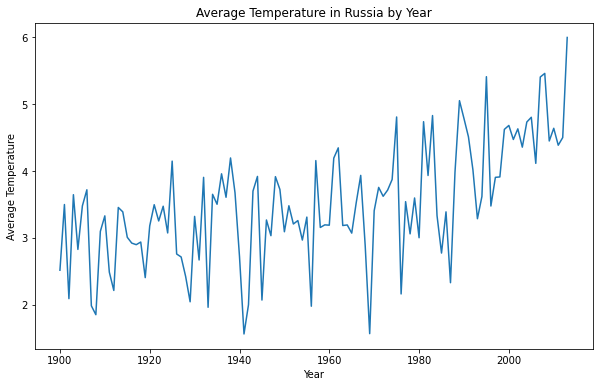

In [28]:
%matplotlib inline

country = input("Please enter a country name: ")   # Please enter the name of the country that you want to plot the graph for.

# The data of the entered country is filtered
df_filtered = df_1900[df_1900['Country'] == country]

# Calculated the average temperatures over the years
df_grouped = df_filtered.groupby(df_filtered.dt.dt.year)['AverageTemperature'].mean().reset_index()

# Data is visualized with a line chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_grouped['dt'], df_grouped['AverageTemperature'])
ax.set_xlabel('Year')
ax.set_ylabel('Average Temperature')
ax.set_title(f'Average Temperature in {country} by Year')
plt.show()

If you want to see the graph of more than one country at the same time, you can run the code below.

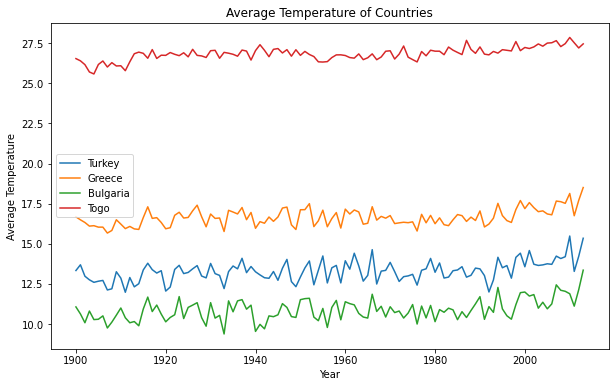

In [62]:
%matplotlib inline

first_country = input("Please enter a country name: ")   # Please enter the name of the first country that you want to plot the graph for.
second_country = input("Please enter a country name: ")   # Please enter the name of the second country that you want to plot the graph for.
third_country = input("Please enter a country name: ")   # Please enter the name of the third country that you want to plot the graph for.
forth_country = input("Please enter a country name: ")   # Please enter the name of the forth country that you want to plot the graph for.

countries = [first_country , second_country, third_country, forth_country]

fig, ax = plt.subplots(figsize=(10, 6))

for country in countries:
    # The data of the entered country is filtered
    df_filtered = df_1900[df_1900['Country'] == country]

    # Calculated the average temperatures over the years
    df_grouped = df_filtered.groupby(df_filtered.dt.dt.year)['AverageTemperature'].mean().reset_index()

    # Data is visualized with a line chart
    ax.plot(df_grouped['dt'], df_grouped['AverageTemperature'], label=country)

ax.set_xlabel('Year')
ax.set_ylabel('Average Temperature')
ax.set_title('Average Temperature of Countries')
ax.legend()
plt.show()

If you want to see the graph of 5 randomly selected countries at the same time, you can run the code below. Also, if you want to change the number of countries that will be randomly selected, random_items = random.sample(countries, k=5) --> you can change the k value here.

The randomly selected countries to be charted are:  ['Colombia', 'United Kingdom', 'Chile', 'Morocco', 'Germany']


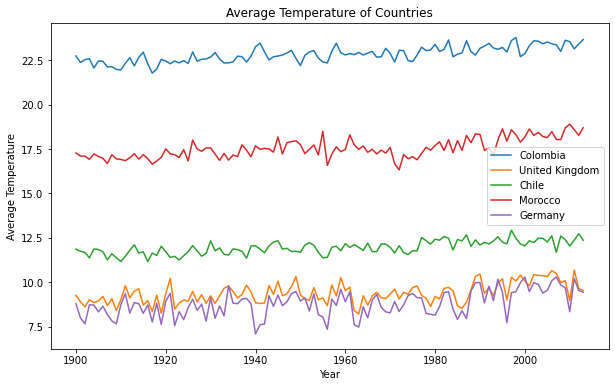

In [63]:
import random

countries = list(df_1900["Country"].unique())

random_items = random.sample(countries, k=5)  # you can change the k value here.

print("The randomly selected countries to be charted are: ", random_items)

fig, ax = plt.subplots(figsize=(10, 6))

for country in random_items:
    # The data of the entered country is filtered
    df_filtered = df_1900[df_1900['Country'] == country]

    # Calculated the average temperatures over the years
    df_grouped = df_filtered.groupby(df_filtered.dt.dt.year)['AverageTemperature'].mean().reset_index()

    # Data is visualized with a line chart
    ax.plot(df_grouped['dt'], df_grouped['AverageTemperature'], label=country)

ax.set_xlabel('Year')
ax.set_ylabel('Average Temperature')
ax.set_title('Average Temperature of Countries')
ax.legend()
plt.show()

If you want to plot the countries with the lowest and highest temperatures among the countries in the data set, you can run the code below.

The country with the lowest average temperature: Mongolia (-3.05°C)
The country with the highest average temperature: Djibouti (29.22°C)


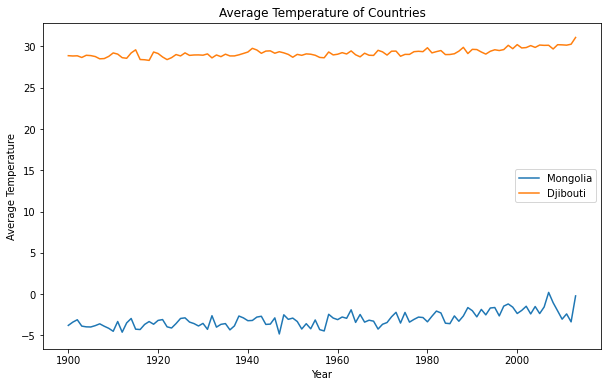

In [64]:
# Average temperature of all countries by year
df_grouped = df_1900.groupby(['Country', df_1900.dt.dt.year])['AverageTemperature'].mean().reset_index()

# Countries sorted by average temperature
df_sorted = df_grouped.groupby('Country')['AverageTemperature'].mean().reset_index().sort_values('AverageTemperature')

# Countries with the lowest and highest average temperatures
lowest_country = df_sorted.iloc[0]['Country']
lowest_avg_temp = df_sorted.iloc[0]['AverageTemperature']
highest_country = df_sorted.iloc[-1]['Country']
highest_avg_temp = df_sorted.iloc[-1]['AverageTemperature']

print(f'The country with the lowest average temperature: {lowest_country} ({lowest_avg_temp:.2f}°C)')
print(f'The country with the highest average temperature: {highest_country} ({highest_avg_temp:.2f}°C)')

countries = [lowest_country, highest_country]

fig, ax = plt.subplots(figsize=(10, 6))

for country in countries:
    # The data of the entered country is filtered
    df_filtered = df_1900[df_1900['Country'] == country]

    # Calculated the average temperatures over the years
    df_grouped = df_filtered.groupby(df_filtered.dt.dt.year)['AverageTemperature'].mean().reset_index()

    # Data is visualized with a line chart
    ax.plot(df_grouped['dt'], df_grouped['AverageTemperature'], label=country)

ax.set_xlabel('Year')
ax.set_ylabel('Average Temperature')
ax.set_title('Average Temperature of Countries')
ax.legend()
plt.show()

Let's take a look at the average temperature change of all countries over the years.

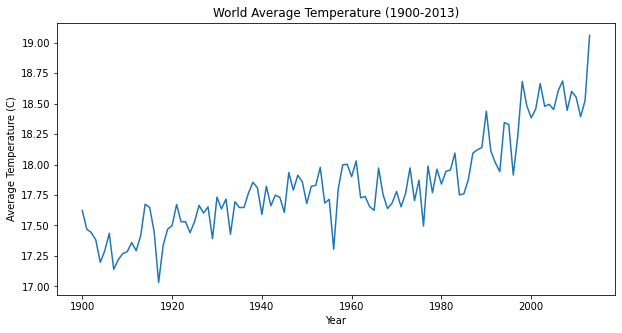

In [37]:
# World average temperatures are calculated over the years
world_avg_temp = df_1900.groupby('Year')['AverageTemperature'].mean()

# Set chart size
plt.figure(figsize=(10, 5))

# Plot the chart
plt.plot(world_avg_temp.index, world_avg_temp.values)

plt.xlabel('Year')
plt.ylabel('Average Temperature (C)')

plt.title('World Average Temperature (1900-2013)')
plt.show()

Now let's find the annual average temperature of the world from 1900 to 2013 and analyze these values as a time series and estimate the average temperature data for the future years.

In [18]:
df_grouped = df_1900.groupby([pd.Grouper(key='dt', freq='Y'), 'Country'])['AverageTemperature'].mean().reset_index()
df_world_yearly = df_grouped.groupby('dt')['AverageTemperature'].mean().reset_index()  # we prepared our data as annual average temperature by groupby method.

In [19]:
df_world_yearly

,dt,AverageTemperature
0,1900-12-31,18.455830
1,1901-12-31,18.383876
2,1902-12-31,18.189352
3,1903-12-31,18.215437
4,1904-12-31,17.980997
...,...,...
109,2009-12-31,19.480607
110,2010-12-31,19.522022
111,2011-12-31,19.324797
112,2012-12-31,19.390649


In [20]:
df_world_yearly.columns = ['ds', 'y'] # We'll use the Prophet library for time series analysis, so we made the column names suitable for the Prophet library (We changed the 'dt' column to 'ds' and the 'AverageTemperature' column to 'y'.).
df_world_yearly = df_world_yearly[:-1] # Since there are only 8 months of data in 2013 (last index), we did not include it in the calculation, excluded it.

In [21]:
m = Prophet()
m.fit(df_world_yearly)

16:28:00 - cmdstanpy - INFO - Chain [1] start processing
16:28:00 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
future = m.make_future_dataframe(periods=17,freq='Y', include_history= True) # We estimated the average temperature data for the period from 2013 to 2030 (17 years).
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
125,2025-12-31,20.111626,19.708512,20.064165,20.081483,20.148176,-0.233834,-0.233834,-0.233834,-0.233834,-0.233834,-0.233834,0.0,0.0,0.0,19.877792
126,2026-12-31,20.137985,19.725103,20.126632,20.103038,20.178834,-0.203208,-0.203208,-0.203208,-0.203208,-0.203208,-0.203208,0.0,0.0,0.0,19.934777
127,2027-12-31,20.164344,19.784314,20.193019,20.123991,20.209701,-0.172553,-0.172553,-0.172553,-0.172553,-0.172553,-0.172553,0.0,0.0,0.0,19.991791
128,2028-12-31,20.190775,19.747389,20.119887,20.145387,20.241999,-0.264395,-0.264395,-0.264395,-0.264395,-0.264395,-0.264395,0.0,0.0,0.0,19.926380
129,2029-12-31,20.217134,19.807816,20.193191,20.167055,20.273319,-0.233834,-0.233834,-0.233834,-0.233834,-0.233834,-0.233834,0.0,0.0,0.0,19.983300


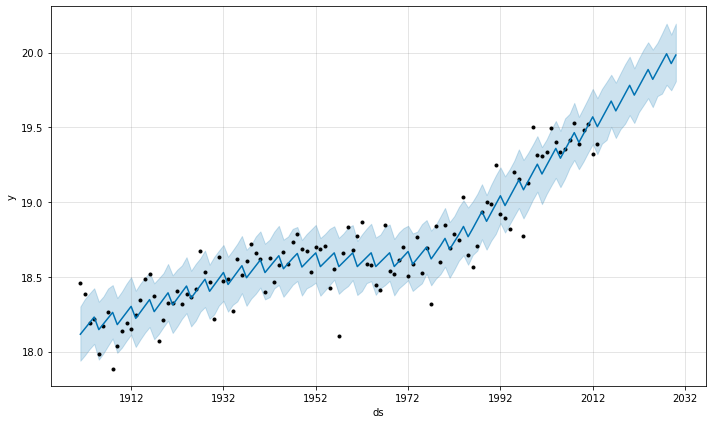

In [23]:
plot1 = m.plot(forecast) # We plotted the data in the dataset and our predictions together. The graph drawn from 2013 to 2030 represents our forecast values. As you can see, Prophet quite reasonably predicted the average temperatures for the future years.

- Let's find out the differences between actual and predicted values for the last 12 years. 
- We will train our model by subtracting the last 12 years from the measured values and then compare the actual results for the last 12 years with the model predicted results.

In [24]:
train = df_world_yearly.drop(df_world_yearly.index[-12:])
print(train.tail())

            ds          y
96  1996-12-31  18.774503
97  1997-12-31  19.128200
98  1998-12-31  19.500157
99  1999-12-31  19.317684
100 2000-12-31  19.305448


In [25]:
model = Prophet()
model.fit(train)

future = list()
for i in range(1, 13):
    date = '2000-%02d' % i
    future.append([date])
    
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

forecast = model.predict(future)

16:28:20 - cmdstanpy - INFO - Chain [1] start processing
16:28:20 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
y_true = df_world_yearly['y'][-12:].values
y_pred = forecast['yhat'].values

In [28]:
mae = mean_absolute_error(y_true, y_pred)
print('Our MAE (mean absolute error) is: %.3f' % mae)

Our MAE (mean absolute error) is: 0.104


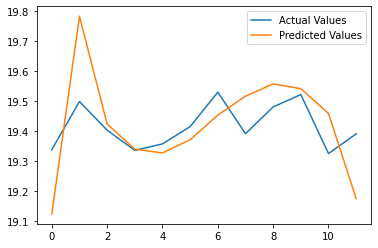

In [29]:
plt.plot(y_true, label='Actual Values')
plt.plot(y_pred, label='Predicted Values')
plt.legend()
plt.show()